In [ ]:
import torch
import torch.nn as nn
from torchvision.transforms import transforms
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
random.seed(100)
torch.manual_seed(100)

In [ ]:
print(len(os.listdir("/content/aa/images")))

63565


In [ ]:
cp "/content/drive/MyDrive/ColabNotebooks/GAN/archive.zip" ./ && unzip ./archive.zip

In [ ]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize((64, 64)),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
dataset = datasets.ImageFolder(root="/content/aa",
                               transform=transform)
dataloader = DataLoader(dataset=dataset,
                        batch_size=128,
                        shuffle=True,
                        num_workers=2)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
print(device)

cuda


In [ ]:
batch = next(iter(dataloader))

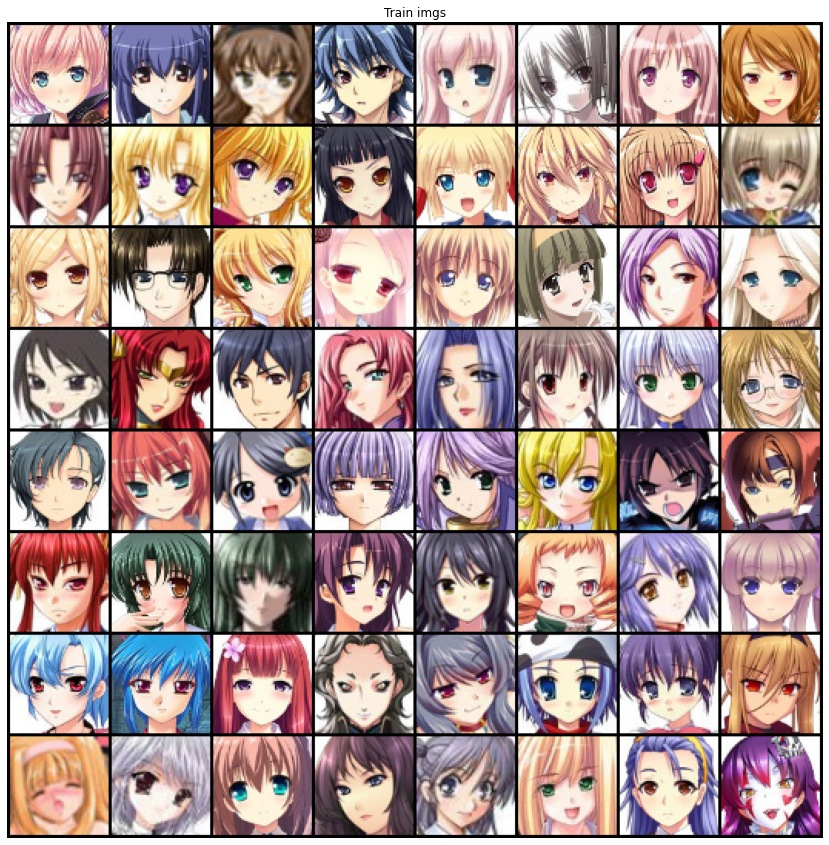

In [ ]:
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.title("Train imgs")
plt.imshow(np.transpose(make_grid(batch[0].detach()[:64], normalize=True).cpu(), (1, 2, 0)))

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.c1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), bias=False)
    self.c2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), bias=False)
    self.c3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), bias=False)
    self.fc1 = nn.Linear(64 * 12 * 12, 512, bias=False)
    self.fc2 = nn.Linear(512, 128, bias=False)
    self.fc3 = nn.Linear(128, 1, bias=False)
    self.mp = nn.MaxPool2d(kernel_size=(2, 2))
    self.act = nn.LeakyReLU(0.2)

  def forward(self, x):
    x = self.act(self.c1(x))
    x = self.mp(x)
    x = self.act(self.c2(x))
    x = self.mp(x)
    x = self.act(self.c3(x))
    x = x.view(-1, 64 * 12 * 12)
    x = self.act(self.fc1(x))
    x = self.act(self.fc2(x))
    x = nn.Sigmoid()(self.fc3(x))
    return x

class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.fc1 = nn.Linear(100, 64 * 58 * 58, bias=False)
    self.c1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), bias=False)
    self.bn1 = nn.BatchNorm2d(32)
    self.c2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), bias=False)
    self.bn2 = nn.BatchNorm2d(16)
    self.c4 = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), bias=False)
    self.act = nn.ReLU()

  def forward(self, x):
    x = self.act(self.fc1(x))
    x = x.view(-1, 64, 58, 58)
    x = self.c1(x)
    x = self.bn1(x)
    x = self.act(x)
    x = self.c2(x)
    x = self.bn2(x)
    x = self.act(x)
    x = nn.Tanh()(self.c4(x))
    return x

In [ ]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

In [ ]:
loss = nn.BCELoss()

g_optimizer = optim.Adam(params=generator.parameters(), lr=0.0000005, betas=(0.5, 0.999))
d_optimizer = optim.Adam(params=discriminator.parameters(), lr=0.0000005, betas=(0.5, 0.999))

In [ ]:
generator.load_state_dict(torch.load("/content/drive/MyDrive/wGan.pth", map_location=torch.device(device)))
discriminator.load_state_dict(torch.load("/content/drive/MyDrive/wGanD.pth", map_location=torch.device(device)))

<All keys matched successfully>

In [ ]:
!cat .config/logs/2021.09.30/17.12.14.546622.log

2021-09-30 17:12:14,548 DEBUG    root            Loaded Command Group: ['gcloud', 'config']
2021-09-30 17:12:14,580 DEBUG    root            Loaded Command Group: ['gcloud', 'config', 'set']
2021-09-30 17:12:14,583 DEBUG    root            Running [gcloud.config.set] with arguments: [SECTION/PROPERTY: "compute/gce_metadata_read_timeout_sec", VALUE: "0"]
2021-09-30 17:12:14,584 INFO     ___FILE_ONLY___ Updated property [compute/gce_metadata_read_timeout_sec].

2021-09-30 17:12:14,586 INFO     root            Display format: "default"
2021-09-30 17:12:14,587 DEBUG    root            SDK update checks are disabled.


Epoch: 1
......................



100%|██████████| 497/497 [01:20<00:00,  6.16it/s]


D_loss: 0.4688452184200287 G_loss: 1.0117228031158447



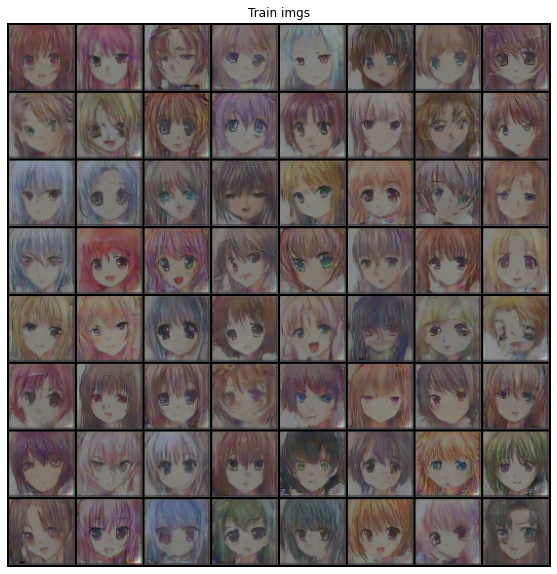

Epoch: 2
......................



100%|██████████| 497/497 [01:21<00:00,  6.13it/s]


D_loss: 0.47132620215415955 G_loss: 1.014609456062317



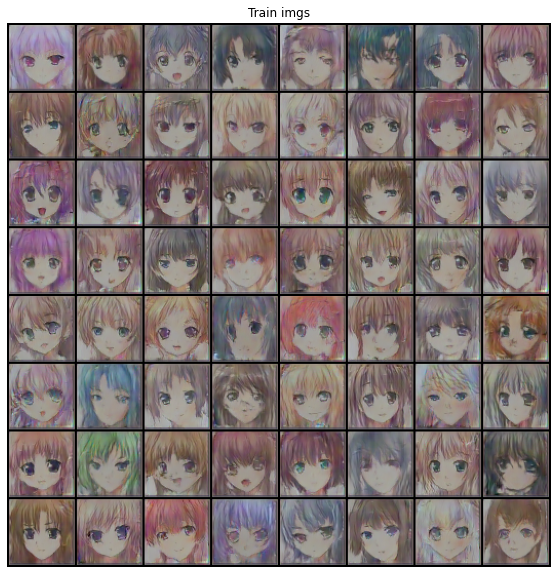

In [ ]:
epochs = 2
generator.train()

for epoch in range(epochs):
  print(f"Epoch: {epoch + 1}\n......................\n")

  for batch, _ in tqdm(dataloader):
    batch = batch.to(device)
    batch_size = batch.shape[0]

    real_label = torch.ones(batch_size, 1, device=device)
    fake_label = torch.zeros(batch_size, 1, device=device)

    discriminator.zero_grad()

    d_pred = discriminator(batch)
    d_loss_real = loss(d_pred, real_label)

    noise = torch.randn(batch_size, 1, 100, device=device)
    g_pred = generator(noise)
    d_pred = discriminator(g_pred.detach())
    d_loss_fake = loss(d_pred, fake_label)

    d_loss = d_loss_fake + d_loss_real
    d_loss.backward()
    d_optimizer.step()

    generator.zero_grad()

    d_pred = discriminator(g_pred)
    g_loss = loss(d_pred, real_label)
    g_loss.backward()
    g_optimizer.step()
  
  print(f"D_loss: {d_loss} G_loss: {g_loss}\n")
  plt.figure(figsize=(10, 10))
  plt.axis("off")
  plt.title("Train imgs")
  plt.imshow(np.transpose(make_grid(g_pred[:64], normalize=True).cpu(), (1, 2, 0)))
  plt.show()

In [ ]:
torch.save(generator.state_dict(), "/content/drive/MyDrive/wGan.pth")

In [ ]:
torch.save(discriminator.state_dict(), "/content/drive/MyDrive/wGanD.pth")

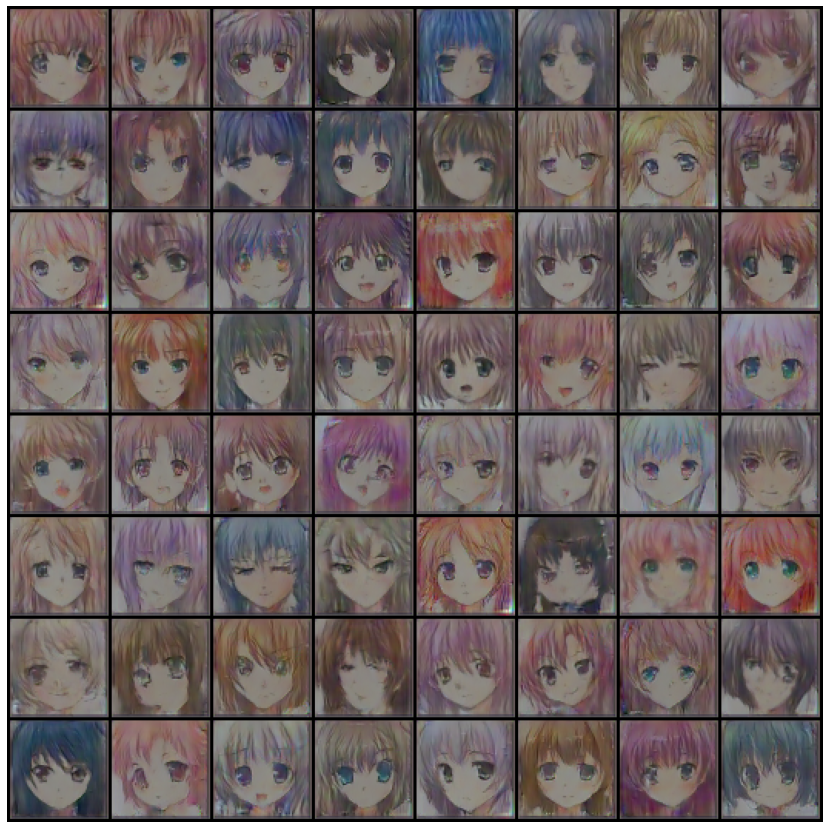

In [ ]:
generator.eval()
pred = generator(torch.randn(64, 1, 100).to(device))
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.imshow(np.transpose(make_grid(pred, normalize=True).cpu(), (1, 2, 0)))